# Thesis Diagrams
This notebook is to generate all code / plots for the thesis document

In [1]:
# Imports
import os
import sys
import json
from pathlib import Path
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List
from sklearn.pipeline import Pipeline

# to enable local imports
module_path = os.path.abspath('code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)


try:
    json_path = (Path(os.getenv('LOCALAPPDATA'))/'Dropbox'/'info.json').resolve()
except FileNotFoundError:
    json_path = (Path(os.getenv('APPDATA'))/'Dropbox'/'info.json').resolve()

with open(str(json_path)) as f:
    j = json.load(f)

personal_dbox_path = Path(j['personal']['path'])
# Save the images directly into the dropbox where the overleaf document is stored
IMAGES_PATH = os.path.join(str(personal_dbox_path), 'Apps', 'Overleaf', 'Masterthesis_Paper', 'images')
print("Saving images to: {}".format(IMAGES_PATH))
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')
    
from data import onlineEegDataDict as subjectDict
from pipelines import filter_signal, prepare_signal, feature_extraction, convert_data
from machine_learning_data_generation import loadOnlineEEGdata, loadPickeldData
from utils import readFileCSV, loadConfigFile, loadFeaturesTxt
from Transfomer_Signal import (BandpassFilter, BandstopFilter, ReplaceOutliers,
                                CenterData, ResampleSignal)

D:\Masterthesis\thesis_eeg\code
Saving images to: D:\Dropbox\Apps\Overleaf\Masterthesis_Paper\images


Using TensorFlow backend.


### Load Online EEG Data

In [2]:
# load the machine learning dataset

##################
# online eeg data
##################
eegData, freqData, entropyData = loadOnlineEEGdata(dirPath='../EEG_Data/eeg_data_online', splitData=False)

X_eeg, y_eeg = eegData
X_freq, y_freq = freqData
X_entropy, y_entropy = entropyData

# load one subject eeg data
epochSeries_1_normal, freqDf_1_normal, entropyArray_normal = loadPickeldData("../EEG_Data/eeg_data_online/1", label="normal")
epochSeries_1_fatigue, freqDf_1_fatigue, entropyArray_fatigue = loadPickeldData("../EEG_Data/eeg_data_online/1", label="fatigue")

# load one subject raw eeg data
eeg_1_raw_normal = readFileCSV("../EEG_Data/eeg_data_online/1/Fatigue_state_256hz.csv")
eeg_1_raw_fatigue = readFileCSV("../EEG_Data/eeg_data_online/1/Normal_state_256hz.csv")


##################
# experiment data
##################
eegData_exp, freqData_exp, entropyData_exp = loadOnlineEEGdata(dirPath='../EEG_Data/muse_data', splitData=False)

X_eeg_exp, y_eeg_exp = eegData_exp
X_freq_exp, y_freq_exp = freqData_exp
X_entropy_exp, y_entropy_exp = entropyData_exp

# load one subject eeg data
epochSeries_1_awake_exp, freqDf_1_awake_exp, entropyArray_awake_exp = loadPickeldData("../EEG_Data/muse_data/subject_9", label="awake")
epochSeries_1_fatigue_exp, freqDf_1_fatigue_exp, entropyArray_fatigue_exp = loadPickeldData("../EEG_Data/muse_data/subject_9", label="fatigue")

# load one subject raw eeg data
eeg_1_raw_awake_exp = readFileCSV("../EEG_Data/muse_data/subject_9/reaction_game_complete.csv")
eeg_1_raw_fatigue_exp = readFileCSV("../EEG_Data/muse_data/subject_9/driving_fatigue.csv")


Loading Online EEG Data from ../EEG_Data/eeg_data_online ...
Data does not get splitted into train and test!
EEG Data Shape:
(7178, 512, 40) (7178,)
Freq Data Shape:
(1440, 1, 1200) (1440,)
Entropy Data Shape:
(7178, 1, 200) (7178,)
Loading Online EEG Data from ../EEG_Data/muse_data ...
Data does not get splitted into train and test!
EEG Data Shape:
(4724, 512, 4) (4724,)
Freq Data Shape:
(950, 1, 120) (950,)
Entropy Data Shape:
(4724, 1, 20) (4724,)


In [3]:
#eeg_1_raw_normal.head()
eeg_1_raw_awake_exp.head()

,Time:256Hz,Epoch,TP9,AF7,AF8,TP10,Right AUX,Event Id,Event Date,Event Duration
0,2020-06-23 15:17:25.312500000,98,10.742188,11.230469,-4.882812,14.160156,0.0,33024.0,12.3125,0.0
1,2020-06-23 15:17:25.316406250,98,8.300781,7.812500,-4.882812,17.089844,0.0,NaN,NaN,NaN
2,2020-06-23 15:17:25.320312500,98,-6.347656,3.906250,-16.113281,-0.488281,0.0,NaN,NaN,NaN
3,2020-06-23 15:17:25.324218750,98,-19.531250,-0.976562,-21.972656,-16.113281,0.0,NaN,NaN,NaN
4,2020-06-23 15:17:25.328125000,98,-7.812500,3.417969,-16.113281,-2.441406,0.0,NaN,NaN,NaN


## Plot Epochs from EEG Signal

In [6]:
def plotWindowFromSeries(epochSeriesNormal, epochSeriesFatigue, window, channel, save_figure=False):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title('EEG Signal comparison - Epoch: {} - Channel: {}'.format(window, channel))
    ax.plot(epochSeriesNormal[window][channel], label="Normal EEG")
    ax.plot(epochSeriesFatigue[window][channel], label="Fatigue EEG")
    plt.legend(loc="upper left")
    ax.set(xlabel='Time / Sample Point', ylabel='Amplitued (normalised)')
    
    if save_figure:
        save_fig("online_eeg_compare_epoch_{}_{}".format(window, channel))  # Not shown

Saving figure online_eeg_compare_epoch_22_channel_7


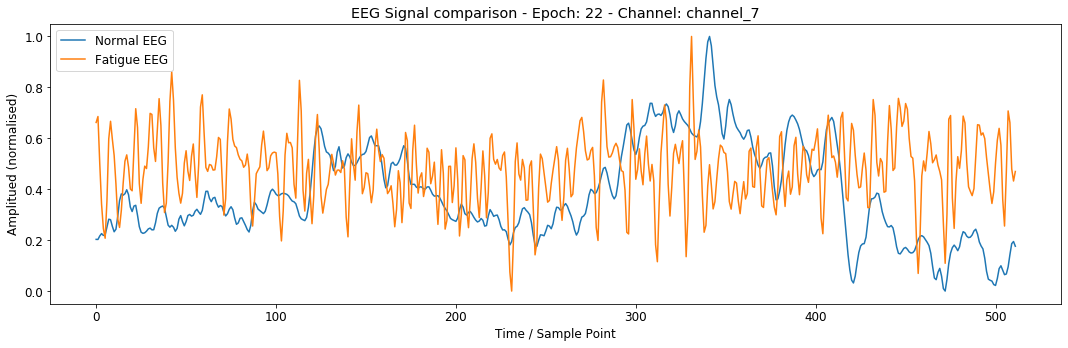

In [5]:
plotWindowFromSeries(epochSeries_1_normal, epochSeries_1_fatigue, window=22, channel="channel_7", save_figure=True)

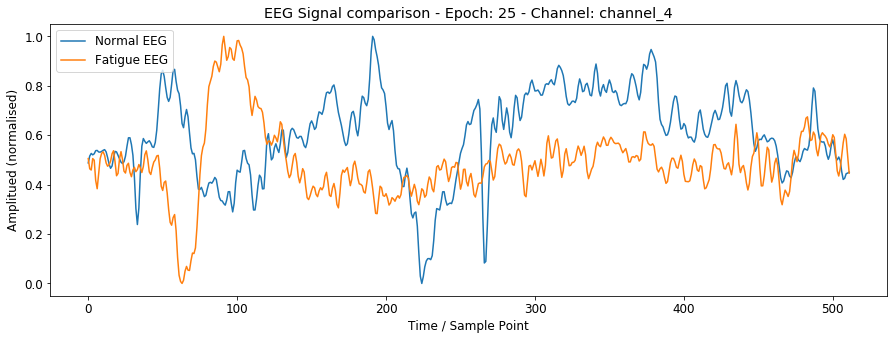

In [12]:
plotWindowFromSeries(epochSeries_1_awake_exp, epochSeries_1_fatigue_exp, window=25, channel="channel_4", save_figure=False)

# Create Bandpass / Bandstop Filter

Saving figure bandpass_bandstop_filter


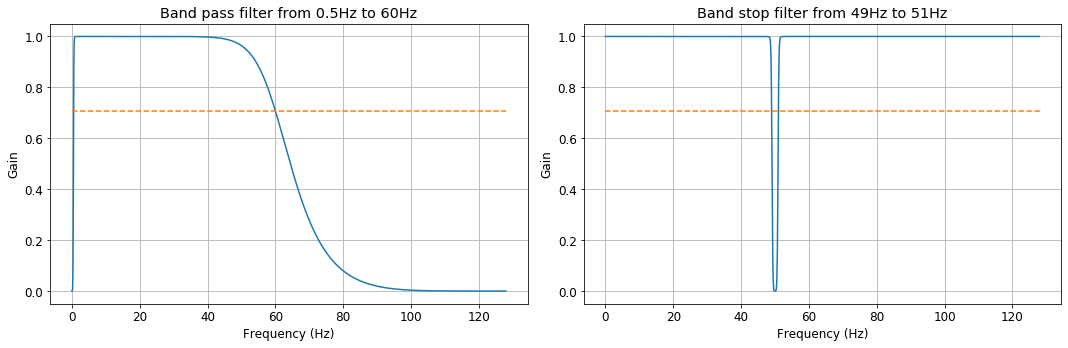

In [29]:
from filterFunctions import butter_bandpass
from scipy.signal import freqz

fs=256
order = 5

# Plot the frequency response for a few different orders.
fig, axs = plt.subplots(1, 2, figsize=(15,5))
b, a = butter_bandpass(lowcut=0.5, highcut=60, fs=fs, btype='band', order=order)
w, h = freqz(b, a, worN=2000)

axs[0].set_title('Band pass filter from 0.5Hz to 60Hz')
axs[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

axs[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
axs[0].set(xlabel='Frequency (Hz)', ylabel='Gain')
axs[0].grid(True)

b, a = butter_bandpass(lowcut=49, highcut=51, fs=256, btype='stop', order=5)
w, h = freqz(b, a, worN=2000)

axs[1].set_title('Band stop filter from 49Hz to 51Hz')
axs[1].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

axs[1].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
axs[1].set(xlabel='Frequency (Hz)', ylabel='Gain')
axs[1].grid(True)
save_fig("bandpass_bandstop_filter")

# Plot Filtering / PSD and Magnitude Spectrum before and after Filtering

In [8]:
def plot_magnitudeFreq_and_PSD(data, samplingRate, signalName, figureName, save_figure=True):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5)) # create 1 x 2 plot

    axes[0].set_title("Magnitude Spectrum - {}".format(signalName))
    axes[0].magnitude_spectrum(data, Fs=samplingRate, scale='dB', color='C1')

    axes[1].set_title("PSD - {}".format(signalName))
    axes[1].psd(data, Fs=samplingRate)

    fig.tight_layout()
    
    if save_figure:
        save_fig(figureName)
    
    plt.show()
    
    

## Online EEG Data

Saving figure online_eeg_channel_7_spektrum


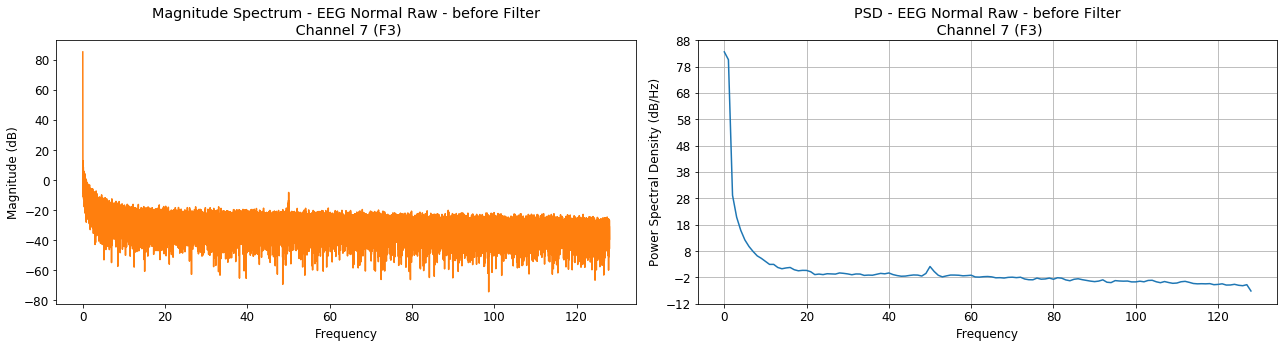

In [22]:
plot_magnitudeFreq_and_PSD(eeg_1_raw_normal['F3'], samplingRate=256, signalName="EEG Normal Raw - before Filter\n Channel 7 (F3)",
                           figureName="online_eeg_channel_7_spektrum")

Saving figure online_eeg_channel_7_spektrum_after_bandpass


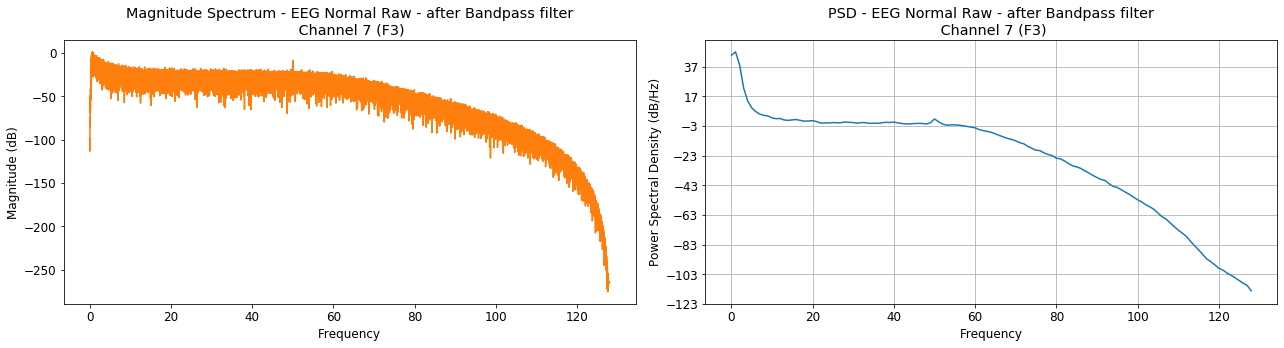

In [23]:
from filterFunctions import butter_bandpass_filter

eeg_1_raw_normal_filtered_ch7 = butter_bandpass_filter(data=eeg_1_raw_normal['F3'], lowcut=0.5, highcut=60, fs=256, btype='band', order=5)
plot_magnitudeFreq_and_PSD(eeg_1_raw_normal_filtered_ch7, samplingRate=256, signalName="EEG Normal Raw - after Bandpass filter\n Channel 7 (F3)",
                           figureName="online_eeg_channel_7_spektrum_after_bandpass")

Saving figure online_eeg_channel_7_spektrum_after_bandpass_bandstop


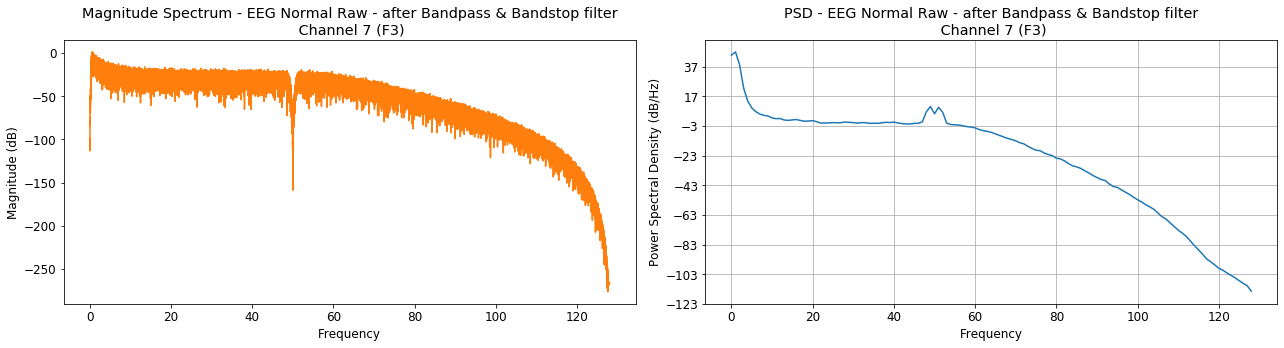

In [24]:
eeg_1_raw_normal_filtered_ch7 = butter_bandpass_filter(data=eeg_1_raw_normal_filtered_ch7, lowcut=49, highcut=51, fs=256, btype='bandstop', order=3)
plot_magnitudeFreq_and_PSD(eeg_1_raw_normal_filtered_ch7, samplingRate=256, signalName="EEG Normal Raw - after Bandpass & Bandstop filter\n Channel 7 (F3)",
                          figureName="online_eeg_channel_7_spektrum_after_bandpass_bandstop")

## Experiment Data

Saving figure experiment_data_channel_3_spektrum


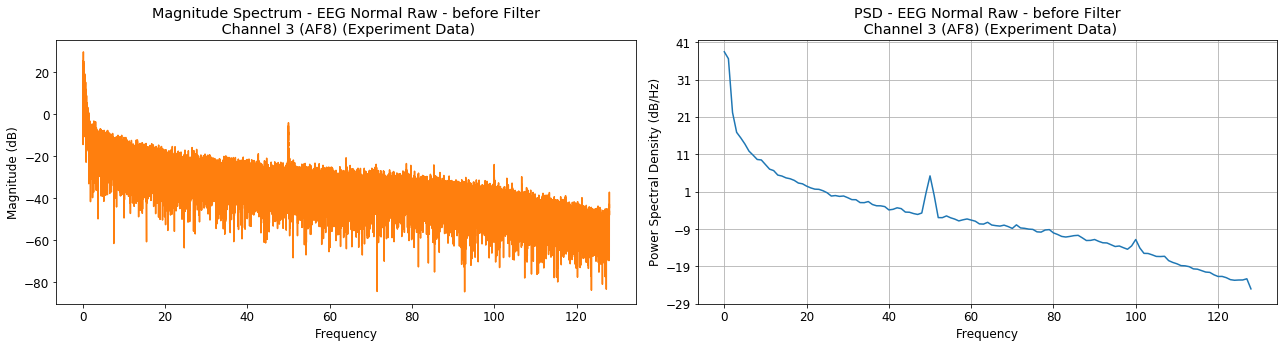

In [26]:
plot_magnitudeFreq_and_PSD(eeg_1_raw_awake_exp['AF8'], samplingRate=256, signalName="EEG Normal Raw - before Filter\n Channel 3 (AF8) (Experiment Data)",
                           figureName="experiment_data_channel_3_spektrum", save_figure=True)

Saving figure experiment_data_channel_3_spektrum_after_bandpass


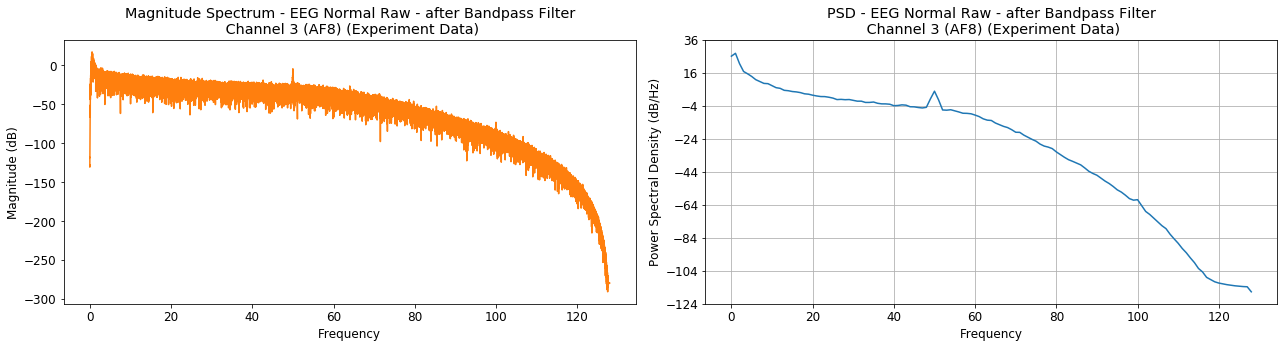

In [27]:
eeg_1_raw_awake_exp_filtered_ch3 = butter_bandpass_filter(data=eeg_1_raw_awake_exp['AF8'], lowcut=0.5, highcut=60, fs=256, btype='band', order=5)
plot_magnitudeFreq_and_PSD(eeg_1_raw_awake_exp_filtered_ch3, samplingRate=256, signalName="EEG Normal Raw - after Bandpass Filter\n Channel 3 (AF8) (Experiment Data)",
                           figureName="experiment_data_channel_3_spektrum_after_bandpass", save_figure=True)

Saving figure experiment_data_channel_3_spektrum_after_bandpass_bandstop


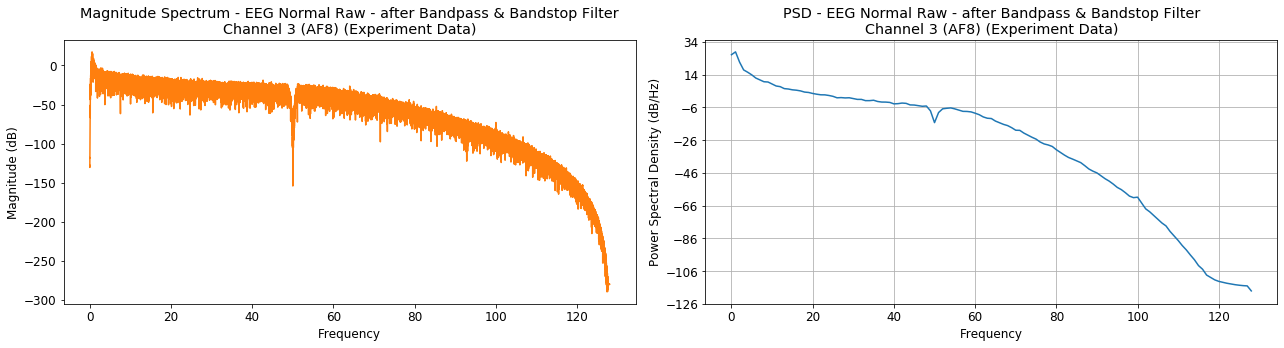

In [28]:
eeg_1_raw_awake_exp_filtered_ch3 = butter_bandpass_filter(data=eeg_1_raw_awake_exp_filtered_ch3, lowcut=49, highcut=51, fs=256, btype='bandstop', order=3)
plot_magnitudeFreq_and_PSD(eeg_1_raw_awake_exp_filtered_ch3, samplingRate=256, signalName="EEG Normal Raw - after Bandpass & Bandstop Filter\nChannel 3 (AF8) (Experiment Data)",
                          figureName="experiment_data_channel_3_spektrum_after_bandpass_bandstop", save_figure=True)

# Show outlier detection

In [33]:
def filter_signal_no_outliers(df : pd.DataFrame, config : Dict) -> pd.DataFrame:
    ''' !Dummy function for showing purposes!
    Filter the signal with bandpass, bandstopp and repace outliers '''

    # signal processing pipeline - e.g. extract the signal from the raw .csv and filter it
    signal_processing_pipeline = Pipeline([
        ('Bandpass Filter', BandpassFilter(device=config['deviceName'], lowcufreq=config['lowcutFreq_bandpass'], highcutfreq=config['highcutFreq_bandpass'], samplingRate=config['samplingRate'])),
        ('Bandstop Filter', BandstopFilter(device=config['deviceName'], lowcufreq=config['lowcutFreq_bandstopp'], highcutfreq=config['highcutFreq_bandstopp'], samplingRate=config['samplingRate'])),
        #('Replace Outliers', ReplaceOutliers(device=config['deviceName'], lowerThreshold=config['lowerThreshold'], upperThreshold=config['upperThreshold']))
    ])
    df = signal_processing_pipeline.fit_transform(df)
    return df

Loading the config file for neuroscan
Saving figure online_eeg_channel_7_outlier_removal


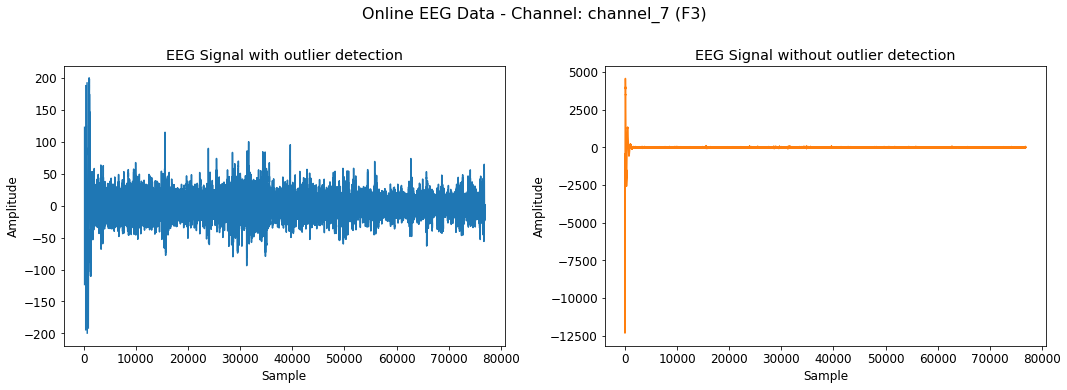

In [35]:
SUBJECT = 1 # Subject to use
# Load the yaml config
yamlConfig = loadConfigFile(subjectDict[SUBJECT]["Device"])
df, featureList = convert_data(df=eeg_1_raw_normal.copy(), config=yamlConfig)

# Filter Signal - with outlier removal
df_no_outliers = filter_signal(df=df.copy(), config=yamlConfig)

# Filter Signal - no outlier removal
df_with_outliers = filter_signal_no_outliers(df=df.copy(), config=yamlConfig)

channel = "channel_7"

fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Online EEG Data - Channel: {} (F3)'.format(channel), fontsize=16, y=1.08)

axs[0].plot(df_no_outliers.index, df_no_outliers[channel])
axs[0].set_title("EEG Signal with outlier detection")
axs[0].set(xlabel='Sample', ylabel='Amplitude')

axs[1].plot(df_no_outliers.index, df_with_outliers[channel], 'tab:orange')
axs[1].set_title("EEG Signal without outlier detection")
axs[1].set(xlabel='Sample', ylabel='Amplitude')
save_fig("online_eeg_{}_outlier_removal".format(channel))

# Show Normalization

In [12]:
from Transformer_Pre_Processing import SlidingWindow, Convert3dArrayToSeriesOfDataframes, NormalizeData, ReplaceNaNs

def prepare_signal_no_normalization(df : pd.DataFrame, config : Dict) -> pd.Series:
    ''' Pre-process the signal by creating epochs, delete faulty epochs and normalize it
    
    Returns a series of dataframes
    '''
    # pre-process the pipeline for machine learning
    pre_processing_pipeline = Pipeline([
        ('Create Epochs', SlidingWindow(samplingRate=config['samplingRate'], windowSizeInSeconds=config['epochWindowSize'], overlapInSeconds=config['overlap'])),
        ('Convert the 3d numpy array', Convert3dArrayToSeriesOfDataframes()), # The pipeline was firstly written for panda dataframes that's why we convert it to a panda series of dataframes
        #('Delete Faulty Epochs', DeleteFaultyEpochs(maxFaultyRate=config['maxFaultyRate'])), # Causes some bugs currently
        #('Normalize Data', NormalizeData()),
        ('Replace NaNs with Zero', ReplaceNaNs()),
    ])
    epochSeries = pre_processing_pipeline.fit_transform(df)
    return epochSeries

SUBJECT = 1 # Subject to use
# Load the yaml config
yamlConfig = loadConfigFile(subjectDict[SUBJECT]["Device"])

epoch_norm = prepare_signal(df=df_no_outliers.copy(), config=yamlConfig)

epoch_no_norm = prepare_signal_no_normalization(df=df_no_outliers.copy(), config=yamlConfig)

Loading the config file for neuroscan
Creating sliding windows...
Converting 3d Numpy Array to a series of Df's
Normalizing data...
Deleting Nan's...
Creating sliding windows...
Converting 3d Numpy Array to a series of Df's
Deleting Nan's...


Saving figure online_eeg_channel_7_normalization


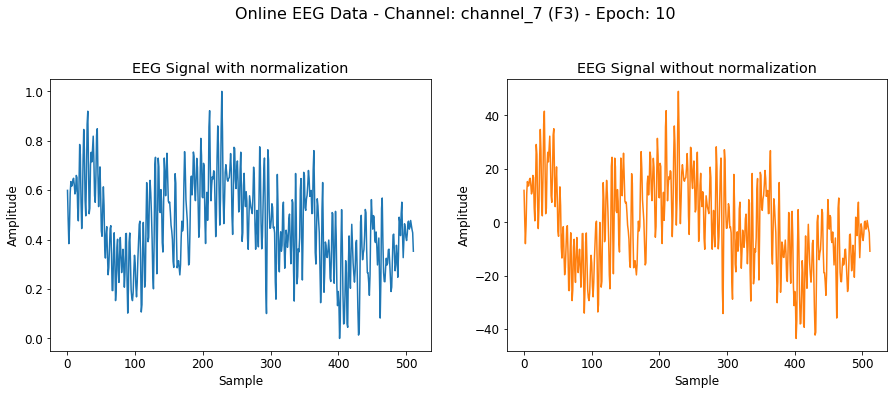

In [40]:
epoch = 10
channel = "channel_7"

fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Online EEG Data - Channel: {} (F3) - Epoch: {}'.format(channel, epoch), fontsize=16, y=1.08)

axs[0].plot(epoch_norm[epoch].index, epoch_norm[epoch][channel])
axs[0].set_title("EEG Signal with normalization")
axs[0].set(xlabel='Sample', ylabel='Amplitude')

axs[1].plot(epoch_no_norm[epoch].index, epoch_no_norm[epoch][channel], 'tab:orange')
axs[1].set_title("EEG Signal without normalization")
axs[1].set(xlabel='Sample', ylabel='Amplitude')
save_fig("online_eeg_{}_normalization".format(channel), tight_layout=False)

# Frequency Analysis
- Relative Bandpower
- Lower & Upper Envelope
- Mean & Std of all

In [14]:
from Transformer_Feature_Extraction import Frequency_Features
# load a config file
yamlConfig = loadConfigFile(subjectDict[SUBJECT]["Device"])

# create a frequency transformer object, to do manually the steps of feature extraction
freq_feature_transformer = Frequency_Features(samplingRate=yamlConfig['samplingRate'],
                                              frequencyBands=yamlConfig['frequencyBands'],
                                              numberOfChannels=yamlConfig['numberOfChannels'])

epoch_series = epoch_norm.copy()

# Little Function to filter dataframes
def filterDf(df, filters):
    for filter_df in filters:
        print("filter by: {}".format(filter_df))
        df = df.filter(like=filter_df)
    return df

Loading the config file for neuroscan
Frequenccy Bands: [(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta'), (30, 50, 'Gamma')]


## Plot Time Domain vs. Frequency Domain

Saving figure online_eeg_channel_7_compare_eeg_frequency


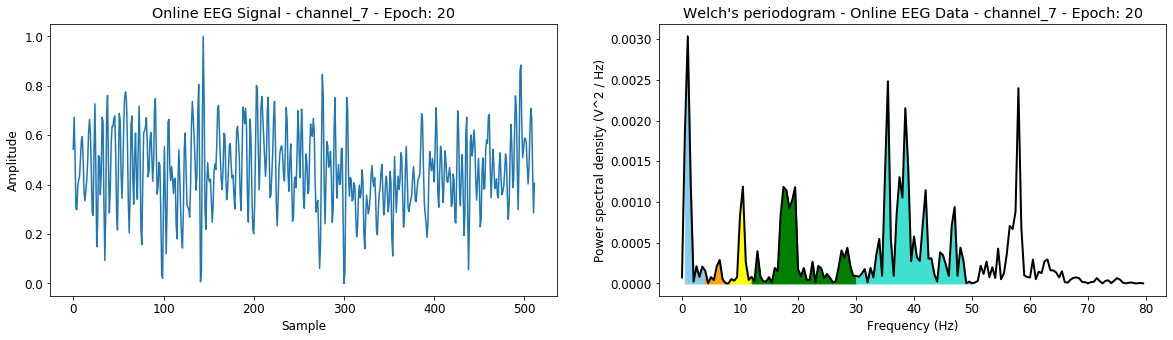

In [15]:
from scipy import signal

epoch = 20
channel = "channel_7"

# Define window length (4 seconds)
sf = 256
win = 2 * sf
freqs, psd = signal.welch(epoch_series[epoch][channel], sf, nperseg=win)

# Define delta lower and upper limits
low_delta, high_delta = 0.5, 4
low_theta, high_theta = 4, 8
low_alpha, high_alpha = 8, 12
low_beta, high_beta = 12, 30
low_gamma, high_gamma = 30, 50


fig, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(epoch_series[epoch][channel].index, epoch_series[epoch][channel])
axs[0].set_title("Online EEG Signal - {} - Epoch: {}".format(channel, epoch))
axs[0].set(xlabel='Sample', ylabel='Amplitude')


freqsPlot = freqs[:int(len(freqs)//1.6)]
psdPlot = psd[:int(len(psd)//1.6)]

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqsPlot >= low_delta, freqsPlot <= high_delta)
idx_theta = np.logical_and(freqsPlot >= low_theta, freqsPlot <= high_theta)
idx_alpha = np.logical_and(freqsPlot >= low_alpha, freqsPlot <= high_alpha)
idx_beta = np.logical_and(freqsPlot >= low_beta, freqsPlot <= high_beta)
idx_gamma = np.logical_and(freqsPlot >= low_gamma, freqsPlot <= high_gamma)

axs[1].plot(freqsPlot, psdPlot, color='k', lw=2)
axs[1].set_title("Welch's periodogram - Online EEG Data - {} - Epoch: {}".format(channel, epoch))
axs[1].set(xlabel='Frequency (Hz)', ylabel='Power spectral density (V^2 / Hz)')

axs[1].fill_between(freqsPlot, psdPlot, where=idx_delta, color='skyblue')
axs[1].fill_between(freqsPlot, psdPlot, where=idx_theta, color='orange')
axs[1].fill_between(freqsPlot, psdPlot, where=idx_alpha, color='yellow')
axs[1].fill_between(freqsPlot, psdPlot, where=idx_beta, color='green')
axs[1].fill_between(freqsPlot, psdPlot, where=idx_gamma, color='turquoise')

save_fig("online_eeg_{}_compare_eeg_frequency".format(channel), tight_layout=False)

## Plot Bandpower over the complete Signal

In [16]:
import yasa

def convertDataFrameToNumpyArray(df : pd.DataFrame) -> np.ndarray:
    npArrayList = []
    for columnName in df:
        npArrayList.append(df[columnName].to_numpy())
    return np.array(npArrayList)

def calculateRelativeFrequencyBands(epochSeries : pd.Series, freqBands, samplingRate=256, relative=True,
                                    kwargsWelch=dict(average='median', window='hamming')) -> pd.Series:
    """ Fucntion take from the code"""
    epochFeatureSeries = []
    for epoch_df in epochSeries:
        dataNpArray = convertDataFrameToNumpyArray(epoch_df)

        # calculate the bandpower for this epoch 
        bandpower_df = yasa.bandpower(data=dataNpArray, 
                                    sf=samplingRate,
                                    ch_names=epoch_df.columns,
                                    win_sec=4, #  e.g. for a lower frequency of interest of 0.5 Hz, the window length should be at least 2 * 1 / 0.5 = 4 seconds
                                    relative=relative, # then the bandpower is already between 0 and 1
                                    bands=freqBands,
                                    kwargs_welch=kwargsWelch) # e.g. (0.5, 4, ‘Delta’)


        epochFeatureSeries.append(bandpower_df)


    return epochFeatureSeries

def updateIndex(df, newIndex, indexToChange):
    as_list = df.index.tolist()
    idx = as_list.index(indexToChange)
    as_list[idx] = newIndex
    df.index = as_list
    return df

In [17]:
freqBands = [(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta'), (30, 50, 'Gamma')]

epochFeatureSeries = calculateRelativeFrequencyBands(epochSeries=epoch_series, freqBands=freqBands)

channelDf = None
for i in range(len(epochFeatureSeries)):
    if channelDf is None:
        channelDf = epochFeatureSeries[i].filter(like=channel, axis='index').copy()
        channelDf = updateIndex(channelDf, i, channel)
    else:
        tempDf = epochFeatureSeries[i].filter(like=channel, axis='index').copy()
        tempDf = updateIndex(tempDf, i, channel)
        channelDf = channelDf.append(tempDf)

channelDf = channelDf.drop(columns=['FreqRes', 'Relative', 'TotalAbsPow'])

C:\Users\reiss\Anaconda3\envs\ml\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 1024 is greater than input length  = 512, using nperseg = 512
  .format(nperseg, input_length))
C:\Users\reiss\Anaconda3\envs\ml\lib\site-packages\yasa\spectral.py:237: RuntimeWarning: invalid value encountered in true_divide
  bp /= total_power


Saving figure online_eeg_channel_7_relative_bandpower


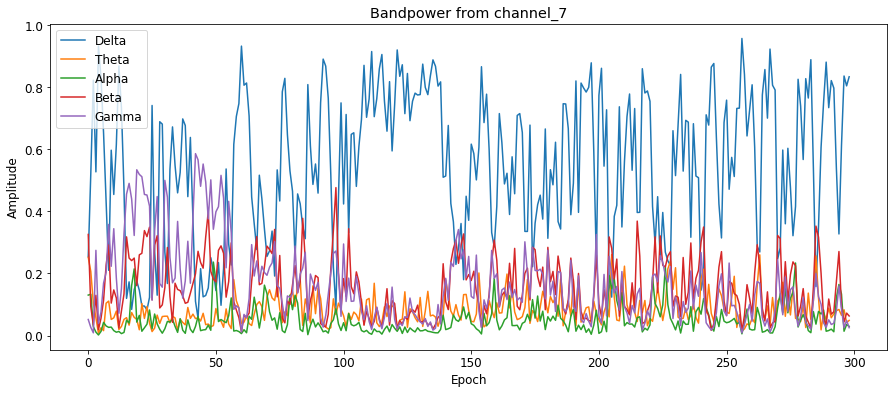

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(15,6))

for column in channelDf:
    axs.plot(channelDf[column], label=column)

axs.set_title("Bandpower from {}".format(channel))
axs.set(xlabel='Epoch', ylabel='Amplitude')
#axs.legend(loc=(1.05,0.6), prop={'size': 14})
axs.legend(loc='best')
save_fig("online_eeg_{}_relative_bandpower".format(channel), tight_layout=False)

## Bandpower lower & upper Envelope

In [19]:
from consts import *
from scipy.interpolate import interp1d

def getEnvelopeModels(aTimeSeries, rejectCloserThan = 0):   
        ''' Copyied from my code '''    
        #Prepend the first value of (s) to the interpolating values. This forces the model to use the same starting point for both the upper and lower envelope models.    
        u_x = [0,]
        u_y = [aTimeSeries[0],]    
        lastPeak = 0
        
        l_x = [0,]
        l_y = [aTimeSeries[0],]
        lastTrough = 0
        
        #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.    
        for k in range(1,len(aTimeSeries)-1):
            #Mark peaks        
            if (np.sign(aTimeSeries[k]-aTimeSeries[k-1])==1) and (np.sign(aTimeSeries[k]-aTimeSeries[k+1])==1) and ((k-lastPeak)>rejectCloserThan):
                u_x.append(k)
                u_y.append(aTimeSeries[k])    
                lastPeak = k
                
            #Mark troughs
            if (np.sign(aTimeSeries[k]-aTimeSeries[k-1])==-1) and ((np.sign(aTimeSeries[k]-aTimeSeries[k+1]))==-1) and ((k-lastTrough)>rejectCloserThan):
                l_x.append(k)
                l_y.append(aTimeSeries[k])
                lastTrough = k
        
        #Append the last value of (s) to the interpolating values. This forces the model to use the same ending point for both the upper and lower envelope models.    
        u_x.append(len(aTimeSeries)-1)
        u_y.append(aTimeSeries[-1])
        
        l_x.append(len(aTimeSeries)-1)
        l_y.append(aTimeSeries[-1])
        
        try:
            #Fit suitable models to the data. Here cubic splines.    
            u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
            l_p = interp1d(l_x,l_y,kind = 'cubic',bounds_error = False, fill_value=0.0)
        except ValueError as e:
            # If there is an error, then there are probably too less values to evalutate
            # print(e) -> The number of derivatives at boundaries does not match: expected 1, got 0+0  (That's the Error I had...)
            return (None, None)
        
        # map the result of interp1d to a list
        u_p = list(map(u_p,range(0,len(aTimeSeries))))
        l_p = list(map(l_p,range(0,len(aTimeSeries))))   
        
        # convert the list of ndarray elemts to a list of float elements
        u_p = np.array(u_p, dtype = float)
        l_p = np.array(l_p, dtype = float)
        
        return (u_p,l_p)

def getValuesFromFeatureEpochs(featureEpochSeries : pd.Series, channelName : str, valueName : str):
    valueList = []
    for epoch in featureEpochSeries:
        try:
            columnValue = epoch[valueName].filter(items=[channelName], axis='index').iloc[0]
        except IndexError: # If there is no value, set it to NaN
            columnValue = np.nan
            #columnValue = 0

        valueList.append(columnValue)
    return valueList

def convertFreqBandsToListAndReturnNames(frequencyBands):
        freqBandNameList = []
        for low, high, band in freqBands:
            freqBandNameList.append(band)
        return freqBandNameList

def createBandpowerUpperLowerEnvelopeDict(epochFeatureSeries : pd.Series, frequencyBandNames : List[str], channelList: List[str], rejectCloserThan : int = 0) -> Dict[str, Dict[str, Dict[str , List[float]]]]:
    ''' Just copied from the code '''

    print("Creating bandpower, lower & upper envelope dictionary...")

    channelFrequencyDict = {}

    for channel in channelList:

        channelFrequencyDict[channel] = {}

        for frequencyBand in frequencyBandNames:

            # first get all values from one channel and one frequency band
            bandpowerValueList = getValuesFromFeatureEpochs(featureEpochSeries=epochFeatureSeries, channelName=channel, valueName=frequencyBand)

            #Estimate models without rejecting any peak
            P = getEnvelopeModels(bandpowerValueList, rejectCloserThan=rejectCloserThan)        
            #Evaluate each model over the domain of (s)
            bandpowerValueList_upper_envelope = P[0]
            bandpowerValueList_lower_envelope = P[1]

            # create a dict for the frequency band
            channelFrequencyDict[channel][frequencyBand] = {}

            # update the dict with the bandpower values
            channelFrequencyDict[channel][frequencyBand][INDEX_BANDPOWER_LIST] = bandpowerValueList
            channelFrequencyDict[channel][frequencyBand][INDEX_BANDPOWER_UPPER_ENVELOPE_LIST] = bandpowerValueList_upper_envelope
            channelFrequencyDict[channel][frequencyBand][INDEX_BANDPOWER_LOWER_ENVELOPE_LIST] = bandpowerValueList_lower_envelope

    return channelFrequencyDict

In [20]:
from utils import createChannelList

numberOfChannels = 40
channelFrequencyDict = createBandpowerUpperLowerEnvelopeDict(epochFeatureSeries=epochFeatureSeries,
                                                             frequencyBandNames=convertFreqBandsToListAndReturnNames(freqBands),
                                                             channelList=createChannelList(numberOfChannels))

Creating bandpower, lower & upper envelope dictionary...


C:\Users\reiss\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sign
C:\Users\reiss\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sign


Saving figure online_eeg_channel_7_relative_bandpower_with_envelopes


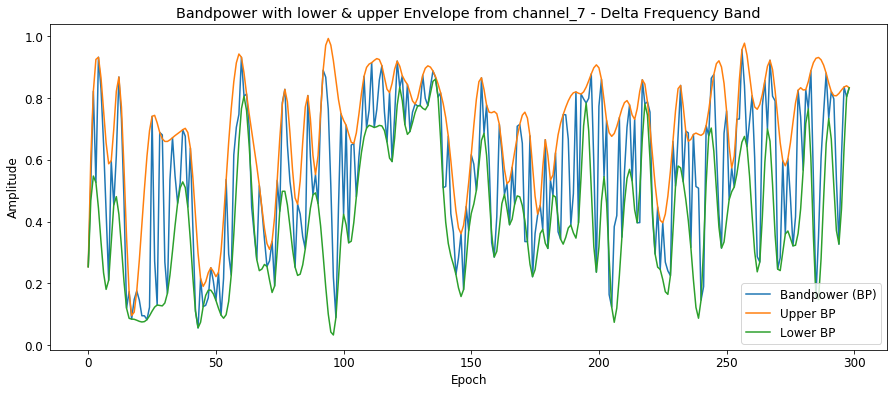

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(15,6))

plotFreqBand = 'Delta'

axs.plot(channelFrequencyDict[channel][plotFreqBand]['bandpower_list'], label='Bandpower (BP)')
axs.plot(channelFrequencyDict[channel][plotFreqBand]['bandpower_upper_envelope_list'], label='Upper BP')
axs.plot(channelFrequencyDict[channel][plotFreqBand]['bandpower_lower_envelope_list'], label='Lower BP')

axs.set_title("Bandpower with lower & upper Envelope from {} - {} Frequency Band".format(channel, plotFreqBand))
axs.set(xlabel='Epoch', ylabel='Amplitude')
#axs.legend(loc=(1.05,0.6), prop={'size': 14})
axs.legend(loc='best')
save_fig("online_eeg_{}_relative_bandpower_with_envelopes".format(channel), tight_layout=False)

## Plot Mean Bandpower vs. Mean Std. Dev.

In [22]:
freqDf = freq_feature_transformer.transform(epoch_series)

C:\Users\reiss\Anaconda3\envs\ml\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 1024 is greater than input length  = 512, using nperseg = 512
  .format(nperseg, input_length))
C:\Users\reiss\Anaconda3\envs\ml\lib\site-packages\yasa\spectral.py:237: RuntimeWarning: invalid value encountered in true_divide
  bp /= total_power


Creating bandpower, lower & upper envelope dictionary...


D:\Masterthesis\thesis_eeg\code\Transformer_Feature_Extraction.py:190: RuntimeWarning: invalid value encountered in sign
  if (np.sign(aTimeSeries[k]-aTimeSeries[k-1])==1) and (np.sign(aTimeSeries[k]-aTimeSeries[k+1])==1) and ((k-lastPeak)>rejectCloserThan):
D:\Masterthesis\thesis_eeg\code\Transformer_Feature_Extraction.py:196: RuntimeWarning: invalid value encountered in sign
  if (np.sign(aTimeSeries[k]-aTimeSeries[k-1])==-1) and ((np.sign(aTimeSeries[k]-aTimeSeries[k+1]))==-1) and ((k-lastTrough)>rejectCloserThan):


Creating statistics bandpower dict...
Creating a nice feature dataframe...


In [23]:
freqDf.head()

,channel_1_Delta_mean_bandpower_list,channel_1_Delta_mean_bandpower_lower_envelope_list,channel_1_Delta_mean_bandpower_upper_envelope_list,channel_1_Delta_std_dev_bandpower_list,channel_1_Delta_std_dev_bandpower_lower_envelope_list,channel_1_Delta_std_dev_bandpower_upper_envelope_list,channel_1_Theta_mean_bandpower_list,channel_1_Theta_mean_bandpower_lower_envelope_list,channel_1_Theta_mean_bandpower_upper_envelope_list,channel_1_Theta_std_dev_bandpower_list,...,channel_40_Beta_mean_bandpower_upper_envelope_list,channel_40_Beta_std_dev_bandpower_list,channel_40_Beta_std_dev_bandpower_lower_envelope_list,channel_40_Beta_std_dev_bandpower_upper_envelope_list,channel_40_Gamma_mean_bandpower_list,channel_40_Gamma_mean_bandpower_lower_envelope_list,channel_40_Gamma_mean_bandpower_upper_envelope_list,channel_40_Gamma_std_dev_bandpower_list,channel_40_Gamma_std_dev_bandpower_lower_envelope_list,channel_40_Gamma_std_dev_bandpower_upper_envelope_list
0,0.634253,0.184375,0.675004,0.313713,0.023659,0.304859,0.133646,0.098968,0.156632,0.082531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.695273,0.386501,0.816828,0.178725,0.095571,0.094390,0.048328,0.024029,0.098061,0.037045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.636144,0.549343,0.697358,0.064849,0.028597,0.025553,0.069679,0.035330,0.093459,0.036242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.340174,0.225219,0.460112,0.147092,0.152283,0.077790,0.076004,0.024427,0.103860,0.031456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.365114,0.063181,0.600532,0.166344,0.058593,0.154539,0.076706,0.048276,0.126506,0.052933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


filter by: channel_7
filter by: mean_bandpower_list
filter by: channel_7
filter by: std_dev_bandpower_list
Saving figure online_eeg_channel_7_compare_freq_bandbower_stddev


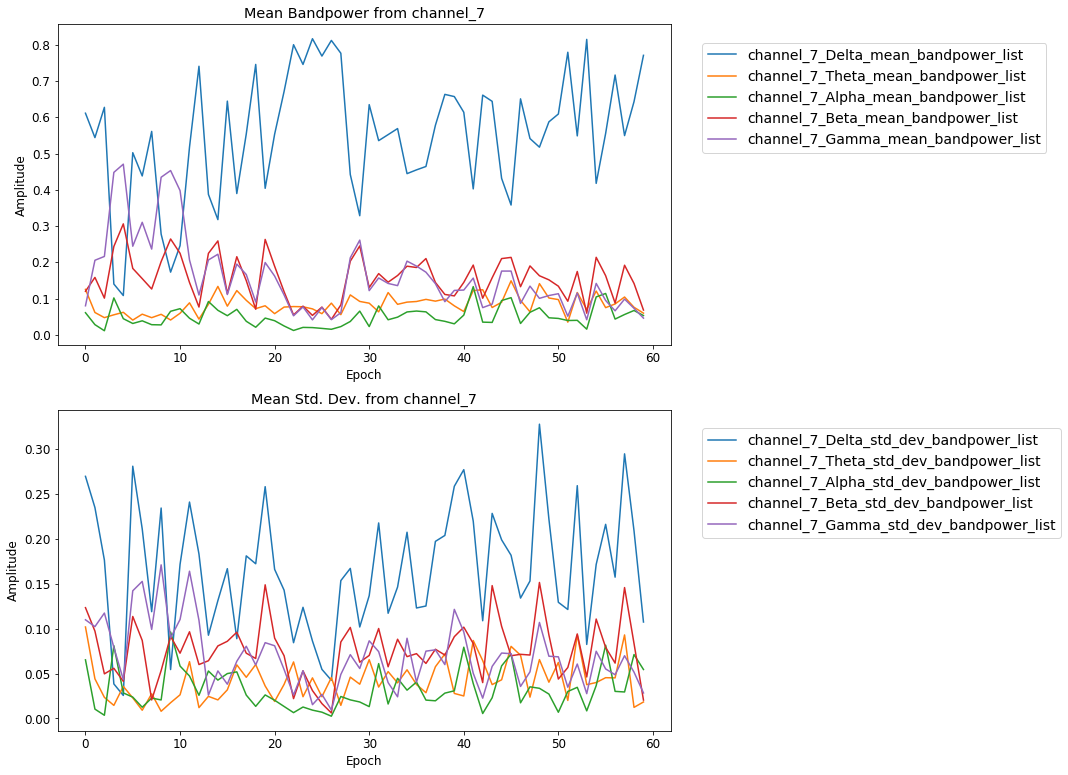

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(11,13))

labels = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
df = filterDf(freqDf.copy(), [channel, "mean_bandpower_list"])
for column, label in zip(df, labels):
    axs[0].plot(df[column], label=column)
    
axs[0].set_title("Mean Bandpower from {}".format(channel))
axs[0].set(xlabel='Epoch', ylabel='Amplitude')
axs[0].legend(loc=(1.05,0.6), prop={'size': 14})


labels = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
df = filterDf(freqDf.copy(), [channel, "std_dev_bandpower_list"])
for column, label in zip(df, labels):
    axs[1].plot(df[column], label=column)

#axs[1].plot(filterDf(freqDf.copy(), [channel, "std_dev_bandpower_list"]))
axs[1].set_title("Mean Std. Dev. from {}".format(channel))
axs[1].set(xlabel='Epoch', ylabel='Amplitude')
axs[1].legend(loc=(1.05,0.6), prop={'size': 14})

save_fig("online_eeg_{}_compare_freq_bandbower_stddev".format(channel), tight_layout=False)

filter by: channel_7
filter by: mean_bandpower
filter by: Delta
filter by: channel_7
filter by: std_dev_bandpower
filter by: Delta
Saving figure online_eeg_channel_7_compare_freq_bandbower_stddev_upper_lower


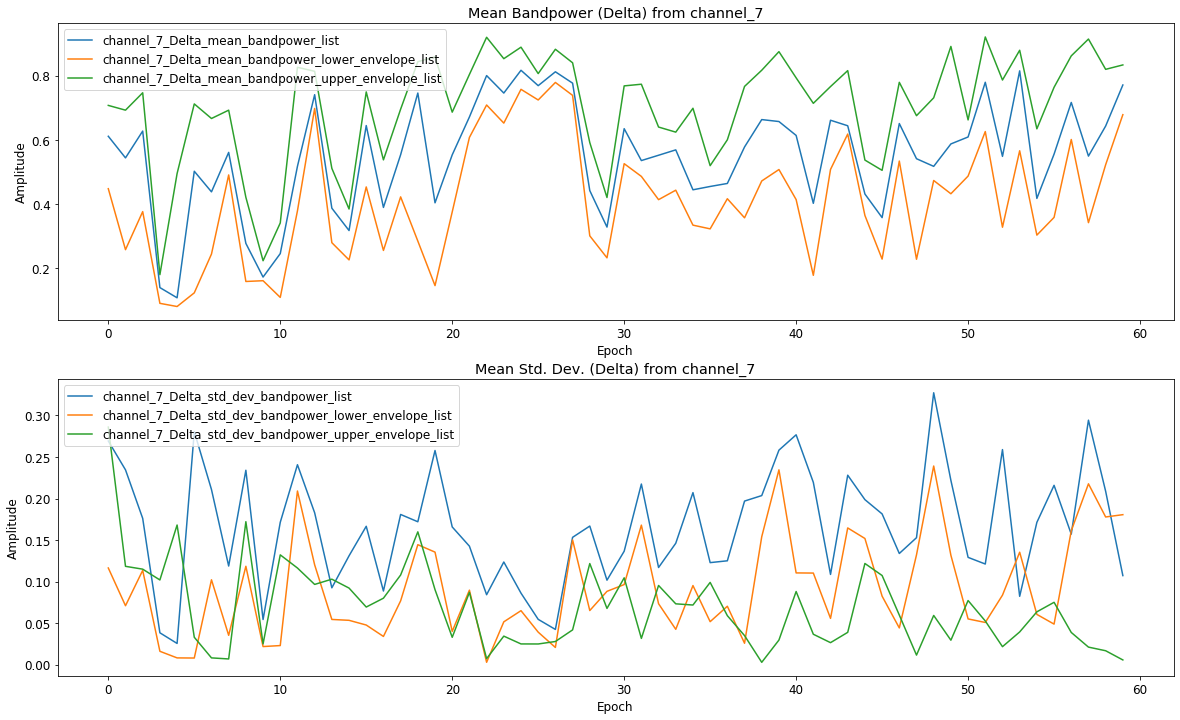

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(20,12))

freq = "Delta"

df = filterDf(freqDf.copy(), [channel, "mean_bandpower", freq])
for column in df:
    axs[0].plot(df[column], label=column)

axs[0].set_title("Mean Bandpower ({}) from {}".format(freq, channel))
axs[0].set(xlabel='Epoch', ylabel='Amplitude')
#axs[0].legend(loc=(1.05,0.6), prop={'size': 14})
axs[0].legend(loc="upper left")

df = filterDf(freqDf.copy(), [channel, "std_dev_bandpower", freq])
for column in df:
    axs[1].plot(df[column], label=column)

#axs[1].plot(filterDf(freqDf.copy(), [channel, "std_dev_bandpower_list"]))
axs[1].set_title("Mean Std. Dev. ({}) from {}".format(freq, channel))
axs[1].set(xlabel='Epoch', ylabel='Amplitude')
#axs[1].legend(loc=(1.05,0.6), prop={'size': 14})
axs[1].legend(loc="upper left")

save_fig("online_eeg_{}_compare_freq_bandbower_stddev_upper_lower".format(channel), tight_layout=False)

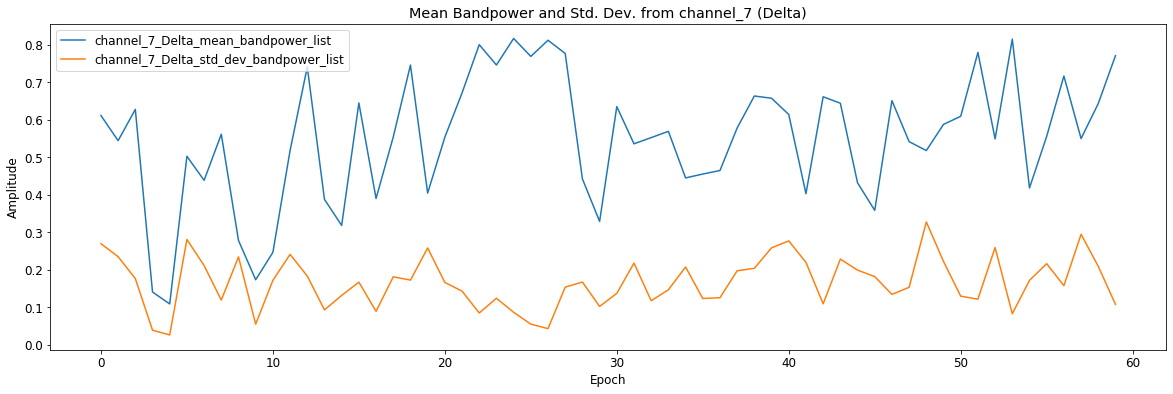

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(20,6))

freq = "Delta"


axs.plot(freqDf.copy().filter(like="channel_7_Delta_mean_bandpower_list"), label="channel_7_Delta_mean_bandpower_list")
axs.plot(freqDf.copy().filter(like="channel_7_Delta_std_dev_bandpower_list"), label="channel_7_Delta_std_dev_bandpower_list")

axs.set_title("Mean Bandpower and Std. Dev. from {ch} ({freq})".format(freq=freq, ch=channel))
axs.set(xlabel='Epoch', ylabel='Amplitude')
#axs[0].legend(loc=(1.05,0.6), prop={'size': 14})
axs.legend(loc="upper left")


# Read entropy feature list

In [8]:
def createEntropyFeaturePlot(entropyArray : np.ndarray, featureIndex, featureList, makeOrange=False):
    fig, ax = plt.subplots(figsize=(15,5))
    
    if type(featureIndex) is list:
        ax.set_title('Entropy Feature Comparison')
        for index in featureIndex:
            ax.plot(entropyArray[:,:,index], label = featureList[index])
        plt.legend(loc="best")
    else:
        ax.set_title('Entropy Feature: {}'.format(featureList[featureIndex]))
        
        if makeOrange:
            ax.plot(entropyArray[:,:,featureIndex], 'tab:orange')
        else:
            ax.plot(entropyArray[:,:,featureIndex])
    
    ax.set(xlabel='Epoch', ylabel='Amplitude')
    return fig, ax

# Read Entropy Feauture List
entropyX_featureList = loadFeaturesTxt("../EEG_Data/eeg_data_online/features_entropy.txt")
entropyX_featureList_exp = loadFeaturesTxt("../EEG_Data/muse_data/features_entropy.txt")

# Approxiamte Entropy

Saving figure online_eeg_channel_7_app_entropy


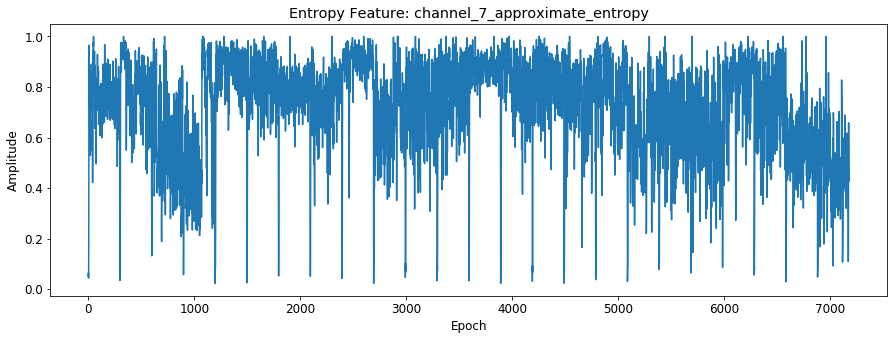

In [48]:
fig, ax = createEntropyFeaturePlot(entropyArray=X_entropy, featureIndex=34, featureList=entropyX_featureList)
save_fig("online_eeg_{}_app_entropy".format(channel), tight_layout=False)

In [9]:
entropyX_featureList_exp

['channel_1_svd_entropy',
 'channel_1_permutation_entropy',
 'channel_1_spectral_entropy',
 'channel_1_sample_entropy',
 'channel_1_approximate_entropy',
 'channel_2_svd_entropy',
 'channel_2_permutation_entropy',
 'channel_2_spectral_entropy',
 'channel_2_sample_entropy',
 'channel_2_approximate_entropy',
 'channel_3_svd_entropy',
 'channel_3_permutation_entropy',
 'channel_3_spectral_entropy',
 'channel_3_sample_entropy',
 'channel_3_approximate_entropy',
 'channel_4_svd_entropy',
 'channel_4_permutation_entropy',
 'channel_4_spectral_entropy',
 'channel_4_sample_entropy',
 'channel_4_approximate_entropy']

numpy.ndarray

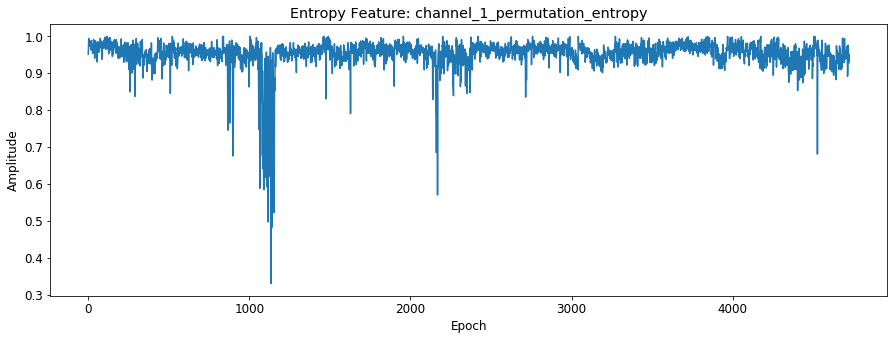

In [23]:
fig, ax = createEntropyFeaturePlot(entropyArray=X_entropy_exp, featureIndex=1, featureList=entropyX_featureList)

# Sample Entropy

Saving figure online_eeg_channel_7_sample_entropy


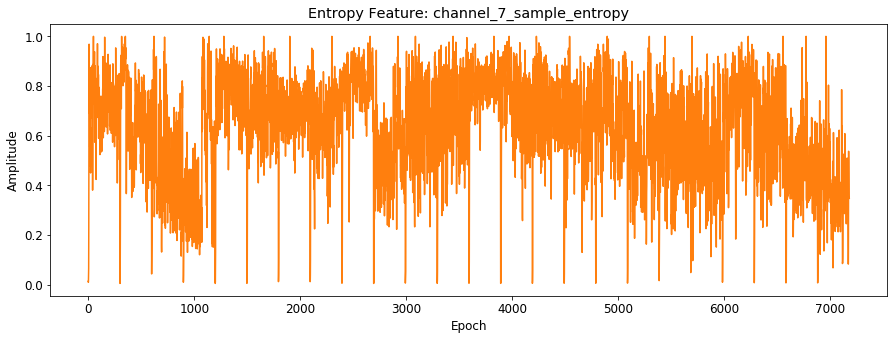

In [49]:
fig, ax = createEntropyFeaturePlot(entropyArray=X_entropy, featureIndex=33, featureList=entropyX_featureList, makeOrange=True)
save_fig("online_eeg_{}_sample_entropy".format(channel), tight_layout=False)

# Spectral Entropy

Saving figure online_eeg_channel_7_spectral_entropy


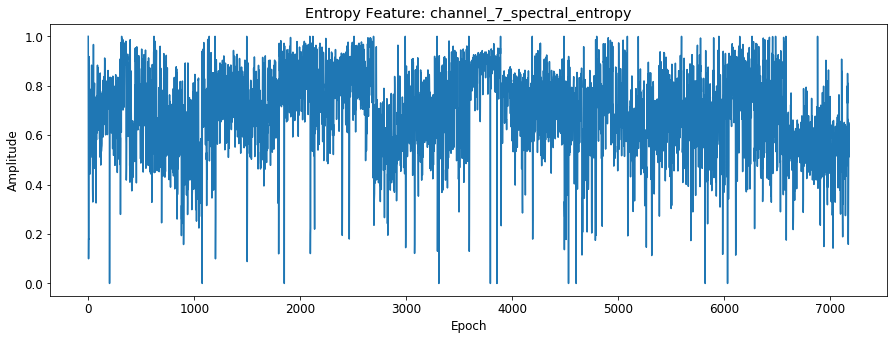

In [50]:
fig, ax = createEntropyFeaturePlot(entropyArray=X_entropy, featureIndex=32, featureList=entropyX_featureList)
save_fig("online_eeg_{}_spectral_entropy".format(channel), tight_layout=False)

# Permutation Entropy

Saving figure online_eeg_channel_7_perm_entropy


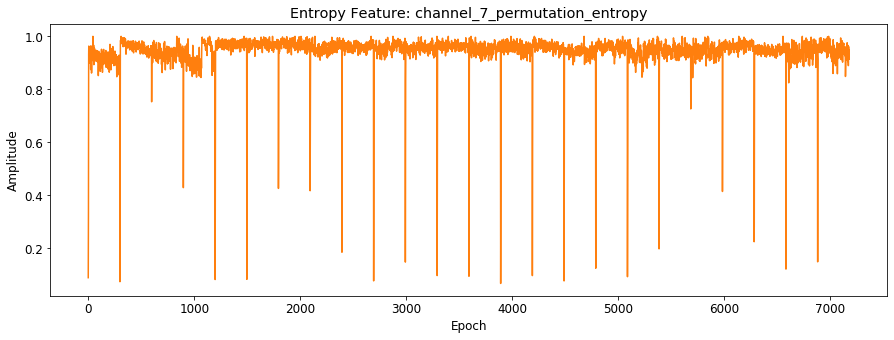

In [51]:
fig, ax = createEntropyFeaturePlot(entropyArray=X_entropy, featureIndex=31, featureList=entropyX_featureList, makeOrange=True)
save_fig("online_eeg_{}_perm_entropy".format(channel), tight_layout=False)

# Singular Value Decompostion Entropy

Saving figure online_eeg_channel_7_svd_entropy


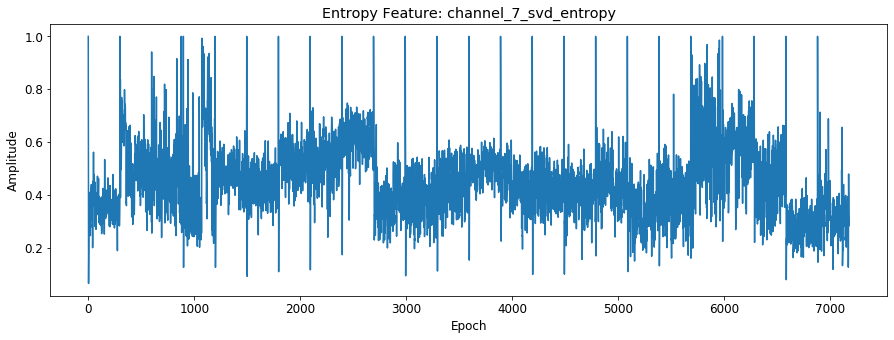

In [53]:
fig, ax = createEntropyFeaturePlot(entropyArray=X_entropy, featureIndex=30, featureList=entropyX_featureList)
save_fig("online_eeg_{}_svd_entropy".format(channel), tight_layout=False)